# Project Overview
I own two microphones, a cheap $3 headset, and a medium quailty podcasting microphone. The difference between the audio recording between these two microphones is that the cheap headset does not capture any frequencies over 7000 Hz, leaving the audio "bassy" and dead. This notebook is an attempt to fill in those higher frequencies using deep learning.

## User Story
As a user, I want to be able to:
1. (Added 10/01/2022) Learn more about Neural Networks, Deep Learning, and TensorFlow.
2. (Added 10/01/2022) Import an audio file recorded on a cheap microphone and use a Neural Network to create a higher quality version.
3. (Added 10/25/2022) Notebook should contain 5 classes.

### Sprint 1 Tasks
Prep Work
- [x] Choose a Dataset
- [x] Learn how to work with tensorflow_datasets
- [x] Create encoding functions (Waveform to Spectragram)
  - [x] Validate waveform can be recovered from STFT
- [x] Look for corelations in spectra to ensure this isn't a waste of time.
  - Completed in a different Jupyter Notebook
- [x] Create "Data Augmentation" functions to simulate low quality recordings
- [x] Learn more about Generators in Python
  - tf.dataset.map function doesn't work with scipy.signals.stft
  - could change to tf.stft, but extra work support User Story #1
- [x] Write generator functions to create (fingerprint, target) pairs for training NN

Train NN
- [x] Train a simple NN!
  - Starting with a simple 2 layer linear NN does two things:
    - Reduces complexity of the system to validate the pipline is working.
    - Establishes a benchmark to compare more complex networks too. Increasing complexity does not guarantee increased performance and may lead to over fitting.
- [x] Measure Performance of NN
  - Quantitative:
    - Cosine_sym after batch(1) learning: 0.858
    - Cosine_sym after batch(5000) learning: ~ 0.95
  - Qualitative:
    - Spectragram, Nice and full. Definitely filled in higher frequencies, but missing transients.
    - To my ear, the input to the NN and the output sound very similar. No improvment, but is does sound like a person talking, so I'll take that as a win!


### Sprint 2 Tasks
Try Deep Learning
- [x] Develop a Deep Learning Model
  - [x] Think really hard about what it is I actually want the computer to do.
  - [x] Create pseudo-code representing my best guess as to what should happen at each layer in the NN.
    - My second attempt is really two NN put together. First a classifier to "turn on and off" certain frequencies, followed by a regression model that reads in the augmented fingerprint (OG fingerprint + classification).
  - [x] Change from sequential NN to functional NN to accommodate the changes above.

Train NN
- [x] Set up pickling to work around Google Colab Walltime.
- [x] Train batch(1) NN
- [x] Train batch(5000) NN
- [x] Measure Performance of NN
  - Quantitative:
    - Cosine_sym after batch(1) learning: 0.8636
    - Cosine_sym after batch(5000) learning: 0.9514
  - Qualitative:
    - Spectragram, similar to Linear, but I need to put them side-by-side.
    - To my ear, the input to the NN and the output sound very similar.

Reflect on Results
- Since the NN is much more complex, but Cosine_sym is similar to the linear case, this suggests to me that there isn't enough information in the fingerprint to make an accurate prediction.
- I'm not entirely surpised by this as the current state-of-the-art is to use convolution NNs. I avoided starting with those due to the additional complexity.
- The current method removes all information about time.
- Before changing to a full on convolution NN, I would like to try adding some recurrent layers (e.g. LSTM) to inject some "time" information into the network.
- External sponsors are requesting at least 5 classes.

### Sprint 3 Tasks
- [ ] Change from functional programming to Object Oriented programming.
  - [x] Timer class, old tic broken
  - [x] create SimpleNN class
  - [x] create CustomPipelines class
  - [x] create STFT class, break old stft
  - [ ] create AudioSample class
    - [x] create LowPassFilter method
  - [x] create LJSpeechAudioSample subclass
  - [ ] create a specialized deep learning subclass
- [ ] Refine documentation of classes and functions
- [ ] Isolate class objects as best we can
- [ ] Learn about recurrent neural networks
- [ ] Pad wave files so they are all the same length of time
- [ ] Create NN#3: a SIMPLE recurrent network (comparable to NN#1)
- [ ] Create NN#4: Add 1 or more recurrent layers to NL NN#2


### Notes to Self
ToDo / deferred
- Set up automatic backups in training
- Add Depth to NN
  - Since we don't know the right hyperparameters (N-layers,layer type, N-neurons, etc) I should probably wrap training into a class that self pickles so I can restart training and add parameters)
- Implement Bootstraping for uncertainty quantification
- Add Checks for convergence

If issues occur
- Try adding Reccurent layers to restore time information.
- Switch to a Convolution NN
- Normalizing might cause issues... As volume decreases, so does the norm of the FFT. Near zero amplitude, normalizing boosts the signal to meaningless noise. I implemented a threshhold. If max() < thresh, norm = 1 to avoid this.
  - We should try without this to see if it matters.
- Try learning from power spectrum instead.


# Setup

In [1]:
# Initialize modules
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds # needs pydub
import pydub

import IPython
import scipy.signal
import scipy.signal
import inspect

import os
import time
import pickle

# Mount personal google drive to save model
# Mounting your gdrive can be done a couple different ways,
# but usually only needs to be done once. Hence, commented out.
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
# stft settings
sample_rate=22050 # Rate from: https://keithito.com/LJ-Speech-Dataset/

# try psd, or without detrend, different overlap and windo sizes, etc.
stft_settings={'fs':sample_rate, # sample rate, # Rate from: https://keithito.com/LJ-Speech-Dataset/
               'nperseg':256*4, # window size
               'window':'hann',
               'detrend':'constant',
              }
               
stft_settings['noverlap']=stft_settings['nperseg']//4 # overlap between fft, window//4

istft_settings = stft_settings.copy()
del istft_settings['detrend']

# Low Pass Filter Settings
LPF_settings={'f1':6000,
              'f2':7000}

In [2]:
# load data, there are lots of possible datasets, but ljspeech is one of the smallest relevant ones. Good for a first attempt.
# Est. Load Time on CPUs: 20 minutes
# https://www.tensorflow.org/datasets/catalog/overview#all_datasets
#t1=tic()
ds = tfds.load('ljspeech', split='train', shuffle_files=False,) # split='train' uses ALL the data for training, for train test splits see: https://www.tensorflow.org/datasets/splits
#t2=tic()
#print("Data loaded in {} minutes".format((t2-t1)/60))

# Define Functions and Generators

In [45]:


### Fingerprinting functions


# Takes a complex STFT and seperates the real and imaginary parts
def ComplexToDual(ComplexSpectra):
  # This works for both 1D and 2D arrays
  REAL = np.real(ComplexSpectra)
  I = np.imag(ComplexSpectra)
  Dual = tf.concat([REAL, I], 0) # slap imaginary part on bottom
  #Dual = [Real,I] # Store real / img parts in a list
  #print(REAL==I) # debug
  return Dual



# Encode a single waveform
def Fingerprint(waveform, sample_rate, stft_obj):
  f, t, sxx = stft_obj.stft(waveform, sample_rate)

  # Split Complex numbers into real an imaginary parts
  sxx = ComplexToDual(sxx)
  # I'd rather augment data than normalize, but training is currently too slow
  fingerprints, norms = NormalizeFP(sxx) # Normalizing might cause issues with small signals

  return f, t, fingerprints, norms





# Encode a single waveform
def Fingerprint_old2(waveform):
  f, t, sxx = stft(waveform, **stft_settings)

  # Split Complex numbers into real an imaginary parts
  sxx = ComplexToDual(sxx)
  # I'd rather augment data than normalize, but training is currently too slow
  fingerprints, norms = NormalizeFP(sxx) # Normalizing might cause issues with small signals

  return f, t, fingerprints, norms

# Encode a single waveform, old generator
def Fingerprint_old1(waveform):
  f, t, sxx = stft(waveform, **stft_settings)
  # Split Complex numbers into real an imaginary parts
  sxx = ComplexToDual(sxx)

  # splits a dualspectra into single FFT slices to run through NN
  for t in range(sxx.shape[1]): # loop over time
    fingerprint = sxx[:,t]
    fingerprint, norm = NormalizeFP_old1(fingerprint) # functionalizing just in case I want to change this
  
    yield (f, t, fingerprint, norm) # idea, fingerprint and norm should be arrays as we can store a whole fingerprint in memory


# Functionalizing just in case I want to change this
def NormalizeFP(sxx, thresh=1):
  norms=np.apply_along_axis(lambda c: max(c) if max(c) > thresh else 1, axis=0, arr=sxx) # pull out max value of each column, if max is near 0, norm is 1 to avoid issues
  fingerprints = np.apply_along_axis(lambda c: c/norms, axis=1, arr=sxx) # divide each row by it's realated column max

  return (fingerprints, norms)


def DenormalizeFP(normedfps, norms):
  fingerprints = np.apply_along_axis(lambda c: c*norms, axis=1, arr=normedfps) # multiply each row by it's related column max
  return fingerprints


def NormalizeFP_old1(fp):
  # I might need to skip / change this
  # As volume decreases, so does norm, NEAR zero this maximizes noise
  # Perhaps it needs a threshold
  norm = max(fp)
  fingerprint = fp/norm

  return (fingerprint, norm)

def DenormalizeFP_old1(normedfp, norm):
  fingerprint = norm*normedfp
  return fingerprint


# takes flattened stft and converts it back to a complex stft
def DualToComplex(fingerprint):
  # Designed for 1D arrays!
  if len(fingerprint)%2 == 0: # if not divisible by two something is wrong...
    nfreq = len(fingerprint)//2
    REAL = fingerprint[:nfreq]
    I = fingerprint[nfreq:]
    COMPLEX = [ complex(r,i) for (r,i) in zip(REAL,I)]
    COMPLEX = np.array(COMPLEX, dtype=np.complex128)
    return COMPLEX
  else:
    print("Issue in DualToComplex, length of fingerprint not divisible by two. Missing Real/Imaginary info.")
    raise


def FingerprintToWave(fps, norms): # _old2
  sxx = DenormalizeFP(fps, norms)
  #print(sxx.shape)
  sxx = [ DualToComplex(s) for s in sxx.T ] # deflatten stft, need to optimize, currently juryrigged
  sxx = np.array(sxx).T # Cols are FFTs
  #print(sxx.shape)
  waveform = istft(sxx, **istft_settings)
  pass # debug
  return waveform

def FingerprintToWave_old1(fp_stack):
  # Unpacking is step one is based on a identity check (FingerprintToWave(Fingerprint(waveform)))
  sxx = [ DenormalizeFP(fp, norm) for (f, t, fp, norm) in fp_stack ] # rows are FFTs
  sxx = [ DualToComplex(s) for s in sxx ] # deflatten stft
  sxx = np.array(sxx).T # Cols are FFTs
  waveform = istft(sxx, **istft_settings)
  pass # debug
  return waveform


def FPtoSpectra(fps, norms): # _old2
  sxx = DenormalizeFP(fps, norms)
  #print(sxx.shape)
  sxx = [ DualToComplex(s) for s in sxx.T ] # deflatten stft, need to optimize, currently juryrigged
  sxx = np.array(sxx).T # Cols are FFTs

  return sxx



### Stay functions? Methods of CustomPipelines?

# A generator for new transformed dataset bc tf.dataset.map function doesn't work with scipy.signals.stft
# We could use tf.stft but what fun is that? I think the window also behaves differently.
def GenerateData(dataset):
  for e in dataset: # iterating bc we can't keep the whole dataset in memory
    waveform = e['speech']
    f, t, fingerprints, norms = Fingerprint(waveform, sample_rate, STFT(**stft_settings))
    f_fps = STFT.low_pass_filter(np.concatenate([f,f]), fingerprints, **LPF_settings)

    for f_fp, fp, norm in zip(f_fps.T, fingerprints.T, norms.T):
      yield (f, t, f_fp, fp, norm)


#@tf.function # this might be helpful?
def GenerateData_old1(dataset):
  for e in dataset:
    waveform = e['speech']

    # SLLLOOOOWWWWW
    for f, t, fp, norm in Fingerprint_old1(waveform): # Fingerprint is a generator
      f_fp = LowPassFilter(np.concatenate([f,f]), fp, **LPF_settings) # should work, check this...
      yield (f, t, f_fp, fp, norm) # given filtered spectra (fingerprint), predict full spectra


#@tf.function # TypeError: To be compatible with tf.function, Python functions must return zero or more Tensors or ExtensionTypes or None values; in compilation of <function GenerateTrainingData at 0x7f60d05c7560>, found return value of type generator, which is not a Tensor or ExtensionType.
def GenerateTrainingData(dataset):
  for f, t, f_fp, fp, norm in GenerateData(dataset):
    yield f_fp, fp

# Define Classes

1. Instead of creating a database of (fingerprint, target) pairs, create a database of "Fingerprint/Datum/Spectra" objects
  - DataAugmentation class?
  - SimulatedCheapMicrophone class?
  - AudioSample class
  - Include methods for visualizing
1. [x] STFT class
  - Create a STFT object
  - AudioSample class can either be handed a STFT obj explicitly, or create one internally.
1. [x] LowPassFilter class, I'd normally do a lambda function, but we need five.
1. [x] SimpleLinearNN class, N layers of M neurons
  - parallel naming style to tf.model, .test, .train, .fit, .predict, .pickle, etc.
  - self pickling
  - settings iterator, (check sklearn, no need to reinvent the wheel)
1. [ ] NLNN1, subclass of simpleNN?
1. [x] Timer class
1. DebugData class, subclass of data?
  - This feels like low hanging fruit, but it's unclear to me how to implement this.
  - A class, that creates an infinite generator object to create a artifical database
1. Wrap plotting stuff in a class?

In [132]:
# A performance timer
class Timer:

  #all_timers = []

  def __init__(self, prec=2):
    self._t0=0
    self.prec=prec
    self.times= []
    #self.all_timers.append(self) # hmm... I'm not sure how I feel about this yet

  def tic(self):
    self._t0 = time.perf_counter()

  def toc(self):
    t1 = time.perf_counter()
    dt = t1-self._t0
    self.times.append(dt)
    
    # Determine if we should report time in hours, minutes, or seconds,
    if dt >= 3600*2: # *2 bc I would rather 90 mins over 1.5 hours
      unit='hours'
      factor=3600
    elif dt >= 60*2: # *2 bc I would rather 75 secs over 1.25 min
      unit='minutes'
      factor=60
    else:
      unit='seconds'
      factor=1

    # Report Runtime
    print(f'Elapsed Time: {round(dt/factor, self.prec)} {unit}')

  def describe(self):
    if len(self.times) > 0:
      print(pd.DataFrame(T.times).describe())
    else:
      print(r'No times recorded')

  def reset(self):
    self.times = []


class CustomPipelines:
  """A container for dataset wrangling related functions.

  I'm not entirely certain how I want to use this class yet.
  Currently, this class is acting like a container for dataset wrangling related functions.
  I might generalize and expand on it later.
  Feeling cute, might delete later.
  """
  def __init__(self, *datasets):
    pass # ToDo, squish all those datasets together
    # format data
    # feed data to NN


  ### Methods

  # A generator for new transformed dataset bc tf.dataset.map function doesn't work with scipy.signals.stft
  # We could use tf.stft but what fun is that? I think the window also behaves differently.
  @staticmethod
  def GenerateData(dataset): # custom pipline 1

    '''
    stft_settings={'nperseg':256*4, # window size
                   'window':'hann',
                   'detrend':'constant',
                  }
    
    stft_obj = STFT(**stft_settings)
    

    # Low Pass Filter Settings
    LPF_settings={'f1':6000,
                  'f2':7000}
    '''

    for e in dataset: # iterating bc we can't keep the whole dataset in memory
      #waveform = e['speech']
      audio_sample = LJSpeechAudioSample(e, stft_obj=stft_obj)
      f, t, fingerprints, norms = Fingerprint(audio_sample.waveform, audio_sample.sample_rate, audio_sample.stft_obj)
      f_fps = STFT.low_pass_filter(np.concatenate([f,f]), fingerprints, **LPF_settings)

      for f_fp, fp, norm in zip(f_fps.T, fingerprints.T, norms.T):
        yield (f, t, f_fp, fp, norm)


  @classmethod
  def GenerateTrainingData(cls, dataset):
    for f, t, f_fp, fp, norm in cls.GenerateData(dataset):
      yield f_fp, fp
  

  # Custom pipeline 1
  @classmethod
  def pipeline1(cls, dataset):
    """pipeline1 is designed to data wrangle the LJSpeech dataset.
    
    """
    # Initilize settings
    stft_settings={'nperseg':256*4, # window size
                   'window':'hann',
                   'detrend':'constant',
                  }
    
    stft_obj = STFT(**stft_settings)
    

    # Low Pass Filter Settings
    LPF_settings={'f1':6000,
                  'f2':7000}


    # Create pipeline object
    pipe = cls()
    stft_obj=STFT(**stft_settings)
    pipe.audio_samples = (LJSpeechAudioSample(e, stft_obj=stft_obj) for e in dataset)
    return pipe

    #DS = tf.data.Dataset.from_generator(lambda: audio_samples_generator(), output_types=(tf.float64, tf.float64) )

    

    return pipe


'''
      f, t, fingerprints, norms = Fingerprint(audio_sample.waveform, audio_sample.sample_rate, audio_sample.stft_obj)
      f_fps = STFT.low_pass_filter(np.concatenate([f,f]), fingerprints, **LPF_settings)

      for f_fp, fp, norm in zip(f_fps.T, fingerprints.T, norms.T):
        yield (f, t, f_fp, fp, norm)
'''
    
    
    #DS = tf.data.Dataset.from_generator(lambda: CustomPipelines.GenerateTrainingData(dataset), output_types=(tf.float64, tf.float64) )
    #return DS





class AudioSample:
  """Holds the properties of an audio file.

  The AudioSample class exists to accumulate information about
  a specific audio sample and allow for easy investigation.
  It can hold information important to machine learning,
  but should not do any heavy lifting by directly.
  """

  def __init__(self, waveform, sample_rate, fingerprinter=None, stft_obj=None):
    self.waveform = waveform
    self.sample_rate = sample_rate
    self.stft_obj = stft_obj
    self.f, self.t, self.sxx = 3*[None]
    
    if fingerprinter is None:
      self.fingerprinter = None
    else:
      self.fingerprinter = fingerprinter
      if self.stft_obj is None:
        self.stft_obj = fingerprinter.stft_obj
      elif fingerprinter.stft_obj is not self.stft_obj:
        print('Warning! AudioSample detected a STFT object was already attached.')
        print('Fingerprinter STFT object differs from AudioSample STFT object!')


  def play_audio(self, normalize=True):
    audio = IPython.display.Audio(self.waveform, rate=self.sample_rate, normalize=normalize)
    IPython.display.display(audio)


  def show_spectra(self, yscale='linear', refresh=False):

    if self.stft_obj is None:
      print('You need to attach a STFT object to plot the STFT!')
      return

    if (None in [self.t, self.f, self.sxx]) or refresh:
      self.f, self.t, self.sxx = self.stft_obj.stft(self.waveform, self.sample_rate)

    self.stft_obj.plot_spectra(self.t, self.f, self.sxx, yscale=yscale)


  '''
  def play_fp(self, normalize=True):
    #wave = # convert fingerprint back to waveform  
    # play wave
    pass # debug
  '''


# 
class LJSpeechAudioSample(AudioSample):
  """A subclass of AudioSample optimized for the LJSpeech database.

  Every database is structured slightly differently.
  Subclasses are one way we can massage differeing datasets into the same form.
  A "from_ljspeech()" static method to AudioSample is another way.
  """
  # Special class to make audio sample from the ljaudio database
  def __init__(self, element, **kwargs):
    # Sample Rate from: https://keithito.com/LJ-Speech-Dataset/
    super().__init__(element['speech'], sample_rate=22050, **kwargs)


class STFT:
  """Creates a Short-Time-Fourier-Transformer."""
  def __init__(self, **stft_settings):
    self.stft_settings = stft_settings

  def stft(self, waveform, sample_rate):
    # filter out unnecessary stft_settings
    sig = inspect.signature(scipy.signal.stft)
    allowed_keys = [ key for key in sig.parameters if key not in ['x', 'fs'] ]
    filtered_settings = { k:self.stft_settings[k] for k in self.stft_settings if k in allowed_keys}
    
    return scipy.signal.stft(waveform, fs=sample_rate, **filtered_settings)

  def istft(self, sxx, sample_rate):
    # filter out unnecessary stft_settings
    sig = inspect.signature(scipy.signal.istft)
    allowed_keys = [ key for key in sig.parameters if key not in ['Zxx', 'fs'] ]
    filtered_settings = { k:self.istft_settings[k] for k in self.istft_settings if k in allowed_keys}
    
    return scipy.signal.istft(sxx, fs=sample_rate, **filtered_settings)


  @staticmethod
  def plot_spectra(t,f,sxx,yscale='linear'):
    # Works for both spectragrams (sxx) and fingerprints (dual form of spectragrams)

    # For complex form
    try:
      y = f
      plt.pcolormesh(t, f, abs(sxx),
                    shading='gouraud', cmap='inferno',
                    norm=colors.LogNorm() # Log COLOR scale
                    )
    # For Dual form
    except TypeError:
      y = np.concatenate([f,-1*f])
      plt.pcolormesh(t, y, abs(sxx),
                    shading='gouraud', cmap='inferno',
                    norm=colors.LogNorm() # Log COLOR scale
                    )
    
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.yscale(yscale)
    plt.ylim(min(y),max(y))
    plt.show()


  # Low-Pass filter to create synthetic data
  @staticmethod
  def low_pass_filter(freqs, sxx, f1, f2):
    # takes in a list of real frequencies and a 2D spectragram (rows = freq, cols = time)
    # reduces / sets the freqs over the cutoff to zero
    # should work on 1D or 2D spectras

    # create mask
    if f1 == f2:
      mask = [ 1 if f < f1  else 0 for f in freqs ] # single row filter
    else:
      mask = [ 1 if f < f1  else 0 if (f > f2)  else (f2-f)/(f2-f1)  for f in freqs ] # single row filter
    
    try:
      mask = [ mask for i in range(sxx.shape[1]) ] # each row is a filter
    except IndexError: # 1D arrays throw an IndexError
      pass

    mask = np.array(mask).T # transpose so each col is a filter

    sxx = mask*sxx # EagerTensor has no copy
    return sxx 



'''
class FingerPrinter:
  def __init__(self, mode=1, stft_obj=None)
  # Split Complex numbers into real an imaginary parts
  sxx = ComplexToDual(self.sxx)
  # I'd rather augment data than normalize, but training is currently too slow
  self.target_fingerprints, self.norms = NormalizeFP(sxx) # Normalizing might cause issues with small signals
'''









"\nclass FingerPrinter:\n  def __init__(self, mode=1, stft_obj=None)\n  # Split Complex numbers into real an imaginary parts\n  sxx = ComplexToDual(self.sxx)\n  # I'd rather augment data than normalize, but training is currently too slow\n  self.target_fingerprints, self.norms = NormalizeFP(sxx) # Normalizing might cause issues with small signals\n"

In [134]:

#pipe = CustomPipelines.pipeline1(ds)
for audio_sample in pipe.audio_samples: #pipe.training_pairs
  audio_sample.play_audio()
  break
'''
S = STFT(**stft_settings)
for e in ds:
  AS = LJSpeechAudioSample(e,stft_obj=S)
  #AS = AudioSample(e['speech'], sample_rate=sample_rate, stft_obj=S)
  break

print(AS)
'''

"\nS = STFT(**stft_settings)\nfor e in ds:\n  AS = LJSpeechAudioSample(e,stft_obj=S)\n  #AS = AudioSample(e['speech'], sample_rate=sample_rate, stft_obj=S)\n  break\n\nprint(AS)\n"

# Debug stuff

In [ ]:
# Debug Data (use this if you don't want to wait for the database to load)
x = np.arange(0,3,1/stft_settings['fs'])
noise = sum([ np.sin(x*f*2*np.pi) for f in np.arange(400,501,100) ])
noise = np.concatenate([noise, sum([ np.sin(x*f*2*np.pi) for f in np.arange(6000,8001,1000) ])])
f, t, Sxx = stft(noise, **stft_settings)
IPython.display.Audio(noise, rate=sample_rate, normalize=True)

In [ ]:
# Debug Data Cont.
pseudods = [ {'speech':noise} ] # list of dicts of waveforms

# Broken since I optimized functions, ignore
for f_fp, fp in GenerateTrainingData(pseudods):
  print( (f_fp == fp)[:10] ) # Should be True
  print()
  print( (f_fp == fp)[-10:] ) # Should be False
  print()
  print(fp == DenormalizeFP(NormalizeFP(fp))) # Should be True
  break

In [ ]:
# Debug Cont.
AudioCheck = FingerprintToWave(Fingerprint(noise))
IPython.display.Audio(AudioCheck, rate=sample_rate, normalize=True)

In [ ]:
# Debug FingerprintToWave
for e in ds:
  waveform = e['speech']
  try:
    del f, t, fingerprints, norms
  except:
    pass
  f, t, fingerprints, norms = Fingerprint(waveform)
  print(fingerprints.shape)
  f_fps = LowPassFilter(np.concatenate([f,f]), fingerprints, **LPF_settings)
  print(f_fps.shape)
  for f_fp, fp, norm in zip(f_fps.T, fingerprints.T, norms.T):
    print(f_fp.shape)
    print(fp.shape)
    print(norm.shape)
    break
  break

In [ ]:
IPython.display.Audio(waveform, rate=sample_rate, normalize=True)

In [ ]:
IPython.display.Audio(FingerprintToWave(FP), rate=sample_rate, normalize=True)

# Define a Simple Dense Neural Network

In [86]:
class SimpleNN:
  def __init__(self, N, M, activation=None, savefile=None, savedir=r'.'):
    # Set up Dense NN
    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1026,)), # I give cols, but tf wants rows
      ])
    
    for i in range(N):
      model.add(keras.layers.Dense(M, activation=activation))
    # Last layer is output layer, fidelity must match number of frequncy bins
    model.add(keras.layers.Dense(1026, activation=activation))

    model.compile(
      optimizer='adam', # try adam, adadelta, and ftrl
      loss="mean_squared_error",
      metrics=["mean_squared_error", 'cosine_similarity'] # Accuracy is only for classifiers. Try MSE and cosine_similarity
      )

    self.model = model
    # Set up autosaving / pickling
    self.savedir=savedir # '/content/drive/MyDrive/Colab Notebooks'
    self.savefile=savefile
    if savefile is None:
      print(r'WARNING! No filename set for saving model. Pickling Impossible!')


  # save model to pickle file
  def pickle(self):
    if self.savefile is None:
      print(r'Set self.savefile="filename.pickle" to enable pickling')
      return
    
    CWD = os.getcwd() # Current working directory
    os.chdir(self.savedir)
    with open(self.savefile, 'wb') as f:
        pickle.dump(self, f)
    os.chdir(CWD)

  # Load model from pickle file
  @staticmethod
  def unpickle(savefile, savedir=r'.'):
    CWD = os.getcwd() # Current working directory
    os.chdir(savedir)
    with open(savefile, 'rb') as f:
        simpleNN = pickle.load(f)
    os.chdir(CWD)

    return simpleNN


# Train our NN! Attempt 1
- Previous training ran about 275ms per slice, or 6 seconds per 32 slice batch on CPUs, previous training ran about 4ms per slice on GPUs
- After optimizing functions this ran at 8ms per slice on CPUs! No batching/prefetch
- For a simple NN with only Input and Output layers with 1026 neurons and linear activation, MSE converges with less than 300,000 slices.
  - There are 2,491,672 slices in the lj dataset.
  - MSE = 0.0055, Cosine_sym= 0.858
- Once training is done we should cluster the dataset based on the MSE.
- Increasing the Batch size seems to have done a great deal to improve the final accuracy (Cosine_sym ~0.95), but additional epochs haven't helped.

In [87]:
# Keep graph clean
from tensorflow.keras import backend as K
K.clear_session()

# Create Training Dataset
DS = CustomPipelines.pipeline1(ds)
T = Timer() # Create Performance Timers

# instantiate Simple Neural Network
T.tic()
simpleNN = SimpleNN(0,1026)
T.toc()

# fit NN
T.tic()
simpleNN.model.fit(DS.prefetch(tf.data.AUTOTUNE), epochs=1, steps_per_epoch=1)
T.toc()

T.tic()
simpleNN.pickle()
T.toc()


WARNING! No filename set for saving model. Pickling Impossible!
Elapsed Time: 0.03 seconds
1/1 [==============================] - 3s 3s/step - loss: 0.0281 - mean_squared_error: 0.0281 - cosine_similarity: -0.0085
Elapsed Time: 3.58 seconds
Set self.savefile="filename.pickle" to enable pickling
Elapsed Time: 0.0 seconds


In [ ]:
import os
CWD = os.getcwd()
print(CWD)

from tensorflow.keras import backend as K
K.clear_session()

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1026,)),
    #keras.layers.Input(shape=(1026,)),
    keras.layers.Dense(1026, activation='relu'), # None means linear activation
])

model.compile(optimizer='adam', # try adam, adadelta, and ftrl
              loss="mean_squared_error",
              metrics=["mean_squared_error", 'cosine_similarity'] # Accuracy is only for classifiers. Try MSE and cosine_similarity
              )


#DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(pseudods), output_types=(tf.float64, tf.float64) )
#DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(ds), output_types=(tf.float64, tf.float64) )
DS = tf.data.Dataset.from_generator(lambda: ShortDataset(GenerateTrainingData(ds),10), output_types=(tf.float64, tf.float64) )

t1=tic()
#model.fit(DS.batch(200).prefetch(tf.data.AUTOTUNE), epochs=1)
#model.fit(DS)
model.fit(DS.prefetch(tf.data.AUTOTUNE), epochs=1)
#model.fit(GenerateTrainingData(ds), epochs=1)
t2=tic()
print("Training: {} hours".format((t2-t1)/(60*60)))

# save model
MLD = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(MLD)
savefile = 'testing.pickle'
#savefile = r'my_model_epoch1.pickle' # linear activation
#savefile = r'my_model_relu_epoch1.pickle'
#import pickle
#with open(savefile, 'wb') as f:
#    pickle.dump(model, f)
os.chdir(CWD)

/content
2491672/2491672 [==============================] - 9489s 4ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - cosine_similarity: 0.5387
Training: 2.6359566333922224 hours


# Train NN, attempt 2
Attempt 1 used a simple 1 layer NN with linear or Relu activation. Linear activation gave a nice, full, spectragram, but lacked some of the fine details. The Relu method was SPARSE, and possibly needed more 1-sample training epochs. Neither method sounded great, but they did seem slightly better.

This section of the notebok is deticated to building more complicated networks by following: https://keras.io/guides/training_with_built_in_methods/

In [ ]:
# Set up saving
#from google.colab import drive
#drive.mount('/content/drive')
import os
CWD = os.getcwd()
print(CWD)

from tensorflow.keras import backend as K
from tensorflow.keras import layers
K.clear_session()

inputs = keras.Input(shape=(1026,), name="inputs") # feed in full STFT slice, 0-11,000ish Hz
categories = layers.Dense(26, activation="softmax", name="categorize")(inputs) # try and categorize slice

upper_fill = layers.Dense(470, activation="tanh", name="upper_fill_OnOff")(categories) # based on category, turn on, or off, different freqs (limited to missing freqs for now)
#upper_fill = layers.Dense(470, activation=None, name="upper_fill")(upper_fill) # fill in upper freqs with linear relationship, can be considered as a non-negative amplitude
upper_fill = layers.Dense(470, activation="relu", name="upper_fill")(upper_fill) # fill in upper freqs with linear relationship, can be considered as a non-negative amplitude

concat = layers.Concatenate(axis=1)([inputs, upper_fill]) # add guess info to OG signal (i.e. increase length of fingerprint)
outputs = layers.Dense(1026, activation=None, name="predictions")(concat) # Must allow for negative values seen in fingerprint
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', # try adam, adadelta, and ftrl
              loss="mean_squared_error",
              metrics=["mean_squared_error", 'cosine_similarity'] # Accuracy is only for classifiers. Try MSE and cosine_similarity
              )


#DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(pseudods), output_types=(tf.float64, tf.float64) )
DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(ds), output_types=(tf.float64, tf.float64) )

t1=tic()
#model.fit(DS.batch(200).prefetch(tf.data.AUTOTUNE), epochs=1)
model.fit(DS.batch(1).prefetch(tf.data.AUTOTUNE), batch_size=1, epochs=1,)# steps_per_epoch=1000) # debug
t2=tic()
print("Training: {} hours".format((t2-t1)/(60*60)))

# save model
savefile = r'deep1_epoch1.pickle'
MLD = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(MLD)
import pickle
with open(savefile, 'wb') as f:
    pickle.dump(model, f)
os.chdir(CWD)

/content
2491672/2491672 [==============================] - 11151s 4ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.8636
Training: 3.106505738496111 hours


# Restart from Pickle


In [ ]:
savefile = r'deep1_epoch1.pickle'
import os
CWD = os.getcwd()
print(CWD)
MLD = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(MLD)
import pickle
t1=tic()
with open(savefile, 'rb') as f:
  model = pickle.load(f)
t2=tic()
os.chdir(CWD)
print("Load: {} seconds".format(t2-t1))


/content
Load: 2.7538030379998872 seconds


In [ ]:
DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(ds), output_types=(tf.float64, tf.float64) )

t1=tic()
model.fit(DS.batch(1).prefetch(tf.data.AUTOTUNE), epochs=4, batch_size=1,)# steps_per_epoch=1000)
t2=tic()
print("Training: {} hours".format((t2-t1)/(60*60)))

# save model
os.chdir(MLD)
with open(r'deep1_epoch5.pickle', 'wb') as f:
    pickle.dump(model, f)
os.chdir(CWD)

In [ ]:
DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(ds), output_types=(tf.float64, tf.float64) )

t1=tic()
model.fit(DS.batch(5000).prefetch(tf.data.AUTOTUNE), epochs=4, batch_size=5000,)# steps_per_epoch=1)
t2=tic()
print("Training: {} hours".format((t2-t1)/(60*60)))

# save model
os.chdir(MLD)
with open(r'deep1_batch5000_epoch4.pickle', 'wb') as f:
    pickle.dump(model, f)
os.chdir(CWD)

Epoch 1/4
499/499 [==============================] - 1040s 2s/step - loss: 0.0023 - mean_squared_error: 0.0023 - cosine_similarity: 0.9452
Epoch 2/4
499/499 [==============================] - 1042s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - cosine_similarity: 0.9513
Epoch 3/4
499/499 [==============================] - 1018s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - cosine_similarity: 0.9514
Epoch 4/4
499/499 [==============================] - 1042s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - cosine_similarity: 0.9514
Training: 1.1506965575074999 hours


# Test it out!

In [ ]:
# Pick an audio file
nmax=1
n=0
for e in ds:
  waveform = e['speech']
  n+=1
  if n >= nmax:
    break

# Fingerprint and predict
f, t, fingerprints, norms = Fingerprint(waveform)

# Simulate Loss in quality
f_fps = LowPassFilter(np.concatenate([f,f]), fingerprints, **LPF_settings)
guess = model.predict(f_fps.T) # "Repair" audio with NN
print(guess.T.shape) 

6/6 [==============================] - 1s 17ms/step
(1026, 167)


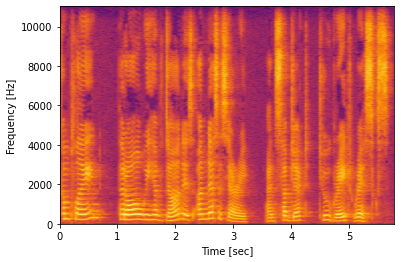

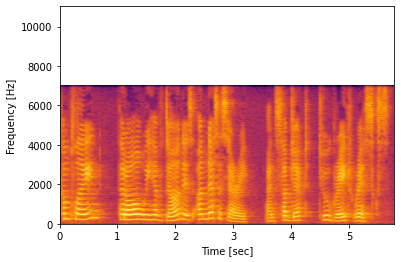

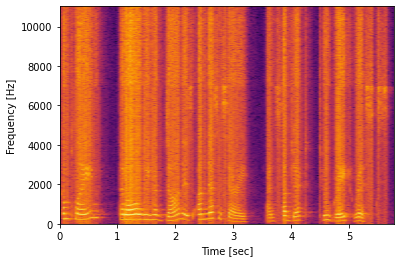

In [ ]:
ShowSpectra(t, f, FPtoSpectra(fingerprints, norms))
ShowSpectra(t, f, FPtoSpectra(f_fps, norms))
ShowSpectra(t, f, FPtoSpectra(guess.T, norms))

In [ ]:
import pandas as pd
look = pd.DataFrame(fingerprints)
look.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
count,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,...,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00
mean,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,...,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00
std,0.12,0.12,0.09,0.05,0.04,0.10,0.13,0.15,0.08,0.09,...,0.18,0.21,0.15,0.16,0.14,0.14,0.17,0.19,0.14,0.12
min,-0.82,-0.97,-1.64,-0.73,-0.57,-2.12,-1.55,-0.68,-0.76,-1.54,...,-1.07,-1.17,-1.04,-1.18,-1.16,-0.80,-1.09,-1.61,-1.12,-0.69
25%,-0.03,-0.04,-0.00,-0.00,-0.00,-0.00,-0.03,-0.06,-0.00,-0.00,...,-0.05,-0.03,-0.02,-0.01,-0.01,-0.01,-0.04,-0.03,-0.03,-0.05
50%,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00
75%,0.03,0.04,0.00,0.00,0.00,0.00,0.03,0.06,0.00,0.00,...,0.05,0.04,0.01,0.01,0.01,0.01,0.04,0.03,0.03,0.05
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.73


In [ ]:
# Listen to "fingerprinted" audio (quality might differ from OG)
filtered_audio = FingerprintToWave(fingerprints,norms)

IPython.display.Audio(filtered_audio, rate=sample_rate, normalize=True)

In [ ]:
# Listen to filtered audio
filtered_audio = FingerprintToWave(f_fps,norms)

IPython.display.Audio(filtered_audio, rate=sample_rate, normalize=True)

In [ ]:
# Listen to "Repaired" Audio
guessed_audio = FingerprintToWave(guess.T,norms)

IPython.display.Audio(filtered_audio, rate=sample_rate, normalize=True)